# Correlation analysis between embeddings and performance metrics

In [1]:
# import dependencies
from text_embedder import TextEmbedder
from gensim import corpora, models
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression

In [2]:
# load pre-trained data
business = pd.read_csv('../data/chinese_business_clean.csv')
reviews = pd.read_csv('../data/chinese_reviews_clean_offsets.csv')

reviews['date_tuple'] = [eval(i) for i in reviews['date_tuple']]
reviews['quarter'] = [eval(i) for i in reviews['quarter']]

# load gensim model
lda =  models.LdaModel.load('../data/gensim/lda.model')
dictionary = corpora.Dictionary.load('../data/gensim/chinsese_dict.dict')

# load idf matrices
with open('../data/u_idf.pickle', 'rb') as f:
    uidf_data = pickle.load(f)
with open('../data/b_idf.pickle', 'rb') as f:
    bidf_data = pickle.load(f)
with open('../data/b_tfidf.pickle', 'rb') as f:
    btfidf_data = pickle.load(f)

In [3]:
# initialize text embedding classs
embedder = TextEmbedder(model = lda, dictionary = dictionary, user_idf = uidf_data, business_idf = bidf_data, business_tfidf = btfidf_data)

In [4]:
# use top2 growing, declining business for case study
case2 = reviews[reviews['business_id'] == 'pH0BLkL4cbxKzu471VZnuA'] # growing 
case3 = reviews[reviews['business_id'] == 'X8c23dur0ll2D9XTu-I8Qg'] # declining

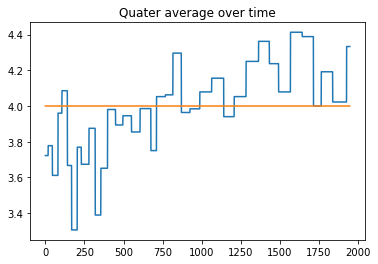

In [5]:
# case2 is growing
plt.plot(case2.sort_values(by= 'quarter')['quarter_avg'].values)
plt.plot(case2.sort_values(by= 'quarter')['business_stars'].values)
plt.title('Quater average over time')
plt.show()

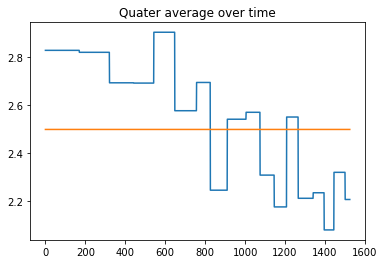

In [6]:
# case3 is declining
plt.plot(case3.sort_values(by= 'quarter')['quarter_avg'].values)
plt.plot(case3.sort_values(by= 'quarter')['business_stars'].values)

plt.title('Quater average over time')
plt.show()

## Raw value of embedded topic vs Business offset

We are going to compare the correlation between the topics and business offsets (review - business average). Offsets are different across reviews, and this metric suggests how positive/negative the topic is given the business

In [7]:
# helper to make a labels 
def mapping(x):
    if x < 0:
        return 0
    else:
        return int(x!=0)+1

In [8]:
# embedding helper class
def embed_by_enum(data, embedder, enum = 0, binary = False):
    # select regions
    if binary:
        data = data[data['business_offset'] != 0]
    label = data['business_offset']
    # create labels
    if enum == 2: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['text'].values, data['user_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    elif enum == 5: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['text'].values, data['user_id'].values, data['business_id'].values)])
    
    elif enum == 0: 
        embed = np.array([embedder.embed(t) for t in data['text'].values])
    elif enum == 1:
        embed = np.array([embedder.embed_sent(t) for t in data['text'].values])
    
    elif enum == 6:
        embed = np.array([embedder.augmented_tf_business_tfidf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

## Case 1 - SUSHISAMBA (growing business)

In [9]:
business[business['business_id'] == 'pH0BLkL4cbxKzu471VZnuA']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
1499,3327 Las Vegas Blvd S,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",pH0BLkL4cbxKzu471VZnuA,"['Nightlife', 'Restaurants', 'Breakfast & Brun...",Las Vegas,"{'Monday': '11:30-1:00', 'Tuesday': '11:30-1:0...",1,36.124582,-115.167553,SUSHISAMBA - Las Vegas,The Strip,89109,1973,4.0,NV


In [10]:
# embedding 

# baseline 
embed, label = embed_by_enum(case2, embedder)
embed1, label1 = embed_by_enum(case2, embedder, enum = 1)

# augmented
embed2, label2 = embed_by_enum(case2, embedder, enum = 2)

# embed3, label3 = embed_by_enum(case2, embedder, enum = 3)
# embed4, label4 = embed_by_enum(case2, embedder, enum = 4)
# embed5, label5 = embed_by_enum(case2, embedder, enum = 5)

# business tfidf 
embed6, label6 = embed_by_enum(case2, embedder, enum = 6)

In [11]:
# print out the correlation coefficients as well as topic distribution
def find_min_max_coef(embed, label):
    coef = []
    for i in range(len(embed[0])):
        coef.append(np.corrcoef(embed[:,i], label)[0, 1])
    coef = np.array(coef)
    coef[np.isnan(coef)] = 0.0
    for i in range(3):
        print ('topic {} : {}'.format(np.argsort(coef)[i], np.sort(coef)[i]))
        print (lda.print_topic(np.argsort(coef)[i], topn=5))
    print ('\n')
    for i in range(3):
        print ('topic {} : {}'.format(np.argsort(coef)[len(coef)-1-i], np.sort(coef)[len(coef)-1-i]))
        print (lda.print_topic(np.argsort(coef)[len(coef)-1-i], topn=5))
    return np.sort(coef)[:10], np.sort(coef)[-10:]

In [12]:
_ = find_min_max_coef(embed, case2['business_offset'])

topic 4 : -0.24252568669703659
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 47 : -0.20185000701962869
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 79 : -0.17917940083499717
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"


topic 46 : 0.2880537534341905
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 62 : 0.14252715193419527
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"
topic 69 : 0.12750849944456055
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


In [13]:
_ = find_min_max_coef(embed1, case2['business_offset'])

topic 117 : -0.22207980406445255
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 4 : -0.20524312471812153
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 79 : -0.19804090668983362
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"


topic 46 : 0.33957077236653854
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 62 : 0.11704571988693614
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"
topic 69 : 0.11479227822266841
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


In [14]:
_ = find_min_max_coef(embed2, case2['business_offset'])

topic 117 : -0.21196428252427693
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 4 : -0.2000375717505413
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"
topic 79 : -0.19756507638245238
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"


topic 46 : 0.3848508710162415
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 62 : 0.13295554494921472
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"
topic 69 : 0.12302300364840482
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


In [15]:
_ = find_min_max_coef(embed6, case2['business_offset'])

topic 117 : -0.21214989721217772
0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time"
topic 79 : -0.20798680737552913
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 4 : -0.19674632558063782
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.37711199071327006
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 62 : 0.12777242569573505
0.014*"like" + 0.013*"good" + 0.011*"ice" + 0.011*"cream" + 0.010*"dessert"
topic 69 : 0.12452062003005454
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


### what is this?

Each embedding is a different representation of text topics, but underlying LDA shares the common word-to-topic distribution. We are comparing the correlation between each topic and 'business-offset'. Here, business-offset is a metric of how positive/negative a given text embedding is, which means, the same exact text might have a different correlation if you are observing different business. 

Positively large correlation means that the topic is important to decide 'strength' of business. For example, from the embedding 0 and embedding 1, we can deduce that the business we are observing is known for good service, sushi and dessert. 

Negatively large correlation means that the topic is important to decide 'weakness' of business. For example, from the embedding 0 and embedding 1, we can deduce that the business we are observing is known for taking long time to bring food.

### Review Recommendation

Use the idea of recomendation system, we can find the most relevant reviews based on this metric.

$[\theta_{0}, \theta_{1}, \theta_{2} ..., \theta_{127}] * [\rho{0}, \rho{1}, \rho{2} ..., \rho{127}]^{T} = r_{d}$

In [16]:
def characteristic_vector(embed):
    coef = []
    for i in range(len(embed[0])):
        coef.append(np.corrcoef(embed[:,i], label)[0, 1])
    coef = np.array(coef)
    coef[np.isnan(coef)] = 0.0
    return np.array(coef)

In [63]:
def positive_feedbacks(df, n, embed):
    vector = characteristic_vector(embed)
    dot = np.array([np.dot(d, vector) for d in embed])
    
    pos_idx = np.argsort(dot)[-n:]
    for i in pos_idx[::-1]:
        print ('Rate: {}\n{}\n'.format(df.iloc[i]['stars'], df.iloc[i]['text']))

def negative_feedbacks(df, n, embed):
    vector = characteristic_vector(embed)
    dot = np.array([np.dot(d, vector) for d in embed])
    
    neg_idx = np.argsort(dot)[:n]
    for i in neg_idx:
        print ('Rate: {}\n{}\n'.format(df.iloc[i]['stars'], df.iloc[i]['text']))

3 least preferable review for this restaurant

In [64]:
negative_feedbacks(case2, 3, embed1)

Rate: 1
Bad sake, very bad raw sea food, extremely bad rice in the sushi, will never let my friends step into this restaurant. I feel curious how can this restaurant get four stars, the sushi bar in my neighborhood is much better than this and only cost 25 dollars each.

Rate: 2
Service was good but the food was just OK.  I am a bit of a sushi snob since my father is a sushi chef but the sushi at this place was nothing special and I've had better at restaurants that were half the price.  I left after one appetizer and 1 roll.

Rate: 2
The sushi is pretty good here, but the service was terrible on my last visit. It took about 10 minutes for someone to even come to our table to get our drink orders,  20 mins after that to actually order, 3 times asking to get refills on water and another 20 mins to get the bill after we asked. This was at 2pm as well, not a busy time. It was very frustrating, and with so many other sushi places around, choose a different one!



3 most prefarable reviews for this restaurant

In [65]:
positive_feedbacks(case2, 3, embed1)

Rate: 5
This place deserves 10 stars, by far my favorite restaurant ever, absolutely love it. Every time we go to visit, this is definitely where we go for dinner, it's not cheap but well worth every penny, everything is always so fresh and delicious, and I mean everything, we always try new things along with some of our favorites and we just love this place more and more each time. The service is impeccable, the servers are very professional and very knowledgeable about the menu and drinks, if you are not sure what to get , just let them how much you are willing to spend and they will create a tasting menu for you, believe you will not be disappointed!!!! Their sea bass skewers and Peruvian corn is a must have! I mean everything is amazing there, hope everyone gets a chance to try this place!

Rate: 5
This is the second time I've been here and it's super delicious. I would highly recommend the family style tasting menu. You try a variety of things that I probably would not have ordere

Without scaling, the recommended reviews are very general positive/negative reviews 

In [66]:
negative_feedbacks(case2, 3, embed2)

Rate: 1
*****the server here was so rude!!!!! worst experience ever. the second we sat down and told her we aren't ordering drinks she kept coming up to our table every 1 min asking what we want to order. we just sat down lady!!! let us look at the menu!!! the food was crappy too. overpriced food ** bad tasting** small portions**rude servers!!!! stay away from the place!!!!

Rate: 3
Not impressed with this Restaraunt. My fiancé food came out late and cold. The waiter mixed up all of the bills. We had to wait on drinks and we never saw our waiter. The water was not refilled and overall customer service experience was poor. However my sushi rolls were great, but a bit on the warm side. It's going to be hard for someone to persuade me to come back here.

Rate: 2
Mediocre food. Average service. Very very close seating (had to move tables to get to seat). Overpriced sushi for tiny pieces. Just expected more from such a nice looking place.



In [67]:
positive_feedbacks(case2, 3, embed2)

Rate: 5
SushiSamba continues to be one of my favorite restaurants in Vegas. We had our wedding rehearsal dinner here with a group of 40 on 8/30. The staff couldn't have been anymore accommodating and friendly. The menu options satisfied everyone's needs. Everything was served family style which we all likes. The firecracker shrimp, truffle aioli and the strip steak were so delicious. My friends and family loved the fun and hip atmosphere. If you ever want to have a group meal I think it doesn't get much better than this!

Rate: 3
This place has some unique flavors going on.  To be totally fair we only tried the appetizers.  The one that stood out in my mind was the duck confit tacos.  Our server was very helpful and attentive.  I think its a must try if you're looking for a quick late night sushi spot for light food.  Much better than the location that closed in Dallas....

Rate: 4
Came here for dinner last weekend and the hype is real: Sushi Samba is a true winner indeed!

The group I

In [68]:
negative_feedbacks(case2, 3, embed6)

Rate: 3
Not impressed with this Restaraunt. My fiancé food came out late and cold. The waiter mixed up all of the bills. We had to wait on drinks and we never saw our waiter. The water was not refilled and overall customer service experience was poor. However my sushi rolls were great, but a bit on the warm side. It's going to be hard for someone to persuade me to come back here.

Rate: 1
Worst place to eat in Vegas!! Right after I was seated my waiter came by and offered to get me water and the only choice he gave me was whether I wanted ice or not. Later, I heard him ask the folks on a nearby table if they would like bottled water, sparkling water or still etc. Then, it took him about 7-8 minutes to come and take my order. And then the food came only 15 minutes later. While I was eating, he never once came to ask me how it was going or whether I wanted anything else. 

I had to ask another waiter to get me some hot tea. The edamame was suspect, some pieces were downright mushy. The s

In [69]:
negative_feedbacks(case2, 3, embed6)

Rate: 3
This place has some unique flavors going on.  To be totally fair we only tried the appetizers.  The one that stood out in my mind was the duck confit tacos.  Our server was very helpful and attentive.  I think its a must try if you're looking for a quick late night sushi spot for light food.  Much better than the location that closed in Dallas....

Rate: 4
Had a great meal here.  The menu is huge and a little overwhelming, but the waiter was very helpful with some suggestions and we wound up doing pretty well. 

The drinks were good, I had mojitos, my group also had a strawberry martini type drink, which I was told was too sweet, and the lemon samurai, which was pretty tasty.

The food was excellent, we had:

Yellowtail Seviche - everyone's favorite, excellent dish, great fish, great seasoning/sauce to it.  I'd have more right now if I could.
Kobe Beef - very good as well, served with mushrooms and sliced super thin.
Beef Tenderloin - which was cooked on the Japanese grill and 

This embedding recommended 3 star review for both most positive and negative; however, we can observe how 2 sentiment differ drastiaclly.

Positive reviews give very specific topics, menu and service, providing concrete feedbacks to the business.
Similarly, nagative reviews provide very specific feedbacks to the business compare to the earlier embedding

# Case2 - Hakkasan Nightclub (declining business)

In [70]:
business[business['business_id'] == 'X8c23dur0ll2D9XTu-I8Qg']

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
3489,"Mgm Grand Hotel And Casino, 3799 Las Vegas Blvd S","{'WheelchairAccessible': True, 'Alcohol': 'ful...",X8c23dur0ll2D9XTu-I8Qg,"['Dance Clubs', 'Cantonese', 'Chinese', 'Loung...",Las Vegas,"{'Sunday': '22:30-4:00', 'Friday': '22:30-4:00...",1,36.101375,-115.172452,Hakkasan Nightclub,The Strip,89109,1547,2.5,NV


In [71]:
# embed
embed, label = embed_by_enum(case3, embedder)
embed1, label1 = embed_by_enum(case3, embedder, enum = 1)
embed2, label2 = embed_by_enum(case3, embedder, enum = 2)
embed6, label6 = embed_by_enum(case3, embedder, enum = 6)

In [73]:
_ = find_min_max_coef(embed, label)

/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


topic 79 : -0.2810142483460295
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.23009044200899803
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 4 : -0.16706551382829352
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 29 : 0.3208614465030524
0.016*"club" + 0.015*"place" + 0.011*"like" + 0.011*"floor" + 0.011*"great"
topic 46 : 0.20176544951055195
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 73 : 0.0828018782714006
0.035*"good" + 0.027*"chinese" + 0.023*"food" + 0.018*"place" + 0.014*"chicken"


In [74]:
_ = find_min_max_coef(embed1, label1)

topic 79 : -0.2714775498508665
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.2066274843148657
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 4 : -0.20135776211830708
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.3145889159554585
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 29 : 0.26088948028741227
0.016*"club" + 0.015*"place" + 0.011*"like" + 0.011*"floor" + 0.011*"great"
topic 69 : 0.09103346731837486
0.023*"sushi" + 0.020*"place" + 0.016*"food" + 0.015*"priced" + 0.012*"vegas"


In [75]:
_ = find_min_max_coef(embed2, label2)

topic 79 : -0.2994402395417848
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.23283445563666547
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 4 : -0.19190047439946087
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.30812538243517135
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 40 : 0.23538182779817926
0.014*"dish" + 0.013*"fried" + 0.013*"chinese" + 0.011*"good" + 0.011*"food"
topic 5 : 0.1669477591816761
0.031*"chicken" + 0.019*"curry" + 0.018*"rice" + 0.015*"like" + 0.013*"food"


In [76]:
_ = find_min_max_coef(embed6, label6)

topic 79 : -0.2949249949269687
0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night"
topic 2 : -0.2240370050578094
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 4 : -0.21551628632845685
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered"


topic 46 : 0.30507048177136387
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly"
topic 40 : 0.2230259618939772
0.014*"dish" + 0.013*"fried" + 0.013*"chinese" + 0.011*"good" + 0.011*"food"
topic 104 : 0.16273965024514903
0.019*"tofu" + 0.016*"good" + 0.011*"food" + 0.011*"sauce" + 0.011*"dish"


### Review Recommendation

In [77]:
positive_feedbacks(case3, 3, embed1)

Rate: 2
This club's layout is such that unless you have a table(i.e bottle service), you're basically always kind of uncomfortable. The dance floor is too small for the crowd, the second floor's view to the dance floor is completely blocked by the tables there, so people kind of flow around narrow passage ways up and down the club, and look for somewhere to be able to stand. The layout gives you the feel of being in somewhat of a maze, and it basically is such that it gives the feeling of saying to you; if you didn't get bottle service, your bad!

Rate: 3
I just wanted to hit a dance club while in Vegas and this one was close in the MGM. I gotta thank my friends for paying for the bottle service and getting us ahead of all the long lines for the bachelor party. Not many clubs in Vegas wanting to let 6 guys in without any females these days! On that note, I had a great time and was glad for the experience. I would say this place was fun, but my favorites in Vegas are still XS and Surren

In [78]:
negative_feedbacks(case3, 3, embed1)

Rate: 1
Experienced a racist encounter with the security staff. Waiting for a response for management. They have ignored and avoided all of my attempts to reach out to them, extremely unprofessional.

Rate: 1
I'm here right now and am sitting next to someone Who works here who told me if I continue to ask him where my credit card is, which has been gone for 30 minutes - that he  will kick me out. I cannot imagine a worse place to spend my night then a place where people people like this exist.

Rate: 2
Bartenders are slow as shit and have an entitled attitude. On average it was taking 30 minutes just to get a drink and when I was there it was not busy.



In [80]:
positive_feedbacks(case3, 3, embed2)

Rate: 4
I don't know why Hakkasan only has 2.5 star. I had a great time there. Only down side was the over the top priced drinks.

Rate: 5
When in Vegas this is a must. We went when Lil Jon was the deejay he had the place lit. Great atmosphere and great music only complaint would be the drinks are a bit pricey but thats Vegas for you. I definitely recommend

Rate: 4
Had an amazing time here! this place is a must place to be if you are in vegas! If you wanna have a great time and hear amazing music by the best Dj's come here! you will not regret it!



In [82]:
negative_feedbacks(case3, 3, embed2)

Rate: 1
If I could give 0 stars i would!  Probably the WORST Club ive ever been to! The Amount of People they let in is Ridiculous to the point you cant even move. 

The Sorry excuse for Bartenders here will ignore you until you somehow manage to pull them your way, they are rude and unfriendly.  A trained monkey can pour a better Jack and Coke. Ordered a Gin and Monster and I got a Red Bull.. ONLY the bull and payed 20 bucks for it. I guess they serve Golden Red Bulls thats what that must have been. It had to be. Wrong! After complaining to the Bar Manager who was even more rude and unhelpful (I see where the "Bartenders" get their manners from) I finally got what i thought was my drink but it turned out to be just water. So they charged me $20 for a redbull and a glass of water. 

After further complaining they just decided to kick my friends and myself out because they didt wanna fix the problem they caused.  

Long story short this place is NOTHING more than a piece of Garbage,  pe

In [81]:
positive_feedbacks(case3, 3, embed6)

Rate: 4
I don't know why Hakkasan only has 2.5 star. I had a great time there. Only down side was the over the top priced drinks.

Rate: 5
When in Vegas this is a must. We went when Lil Jon was the deejay he had the place lit. Great atmosphere and great music only complaint would be the drinks are a bit pricey but thats Vegas for you. I definitely recommend

Rate: 4
I've got no beef with this place. Bought the Tiesto tickets ahead of time so no wait. Staff was pretty friendly for a club. Drank a bunch and ate a xanax beforehand so no need to visit the bar for some bullshit weak cocktails. Show was awesome. I'd go again.



In [83]:
negative_feedbacks(case3, 3, embed6)

Rate: 1
Way oversold. This place is nothing to write home about. Drinks are entirely overpriced: $60 for 2 drinks and 2 tap waters. We were curious and optimistic! But left entirely disappointed. Staff will confiscate any outside food or drink - even if it's sealed. The management was condescending and inconsiderate. Don't waste your time.

Rate: 1
If I could give 0 stars i would!  Probably the WORST Club ive ever been to! The Amount of People they let in is Ridiculous to the point you cant even move. 

The Sorry excuse for Bartenders here will ignore you until you somehow manage to pull them your way, they are rude and unfriendly.  A trained monkey can pour a better Jack and Coke. Ordered a Gin and Monster and I got a Red Bull.. ONLY the bull and payed 20 bucks for it. I guess they serve Golden Red Bulls thats what that must have been. It had to be. Wrong! After complaining to the Bar Manager who was even more rude and unhelpful (I see where the "Bartenders" get their manners from) I 

### What is this

Something I realize is some topics such as Topic 4, topic 117 are recurrently appearing across businesses. This means the negative topics failed to generalize business specific information, but rather, making an observation of tendency that people conplain more about time when it comes to chinese restaurants

# Preliminary time-series analysis

We are going to compare the correlation between the *slope* of topics in a quarter and quarter offsets (quarter average - business average). Positive correlation means topics that the business wants the users to talk more in order to improve the business

In [30]:
def embed_by_enum(data, embedder, enum = 0, binary = False):
    # select regions
    if binary:
        data = data[data['quarter_offset'] != 0]
    label = data['quarter_offset']
    # create labels
    if enum == 2: 
        embed = np.array([embedder.augmented_embed_text(t) for t in data['text'].values])
    elif enum == 3: 
        embed = np.array([embedder.user_tfidf_embed(t, u) for t, u in zip(data['text'].values, data['user_id'].values)])
    elif enum == 4: 
        embed = np.array([embedder.user_tf_business_idf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    elif enum == 5: 
        embed = np.array([embedder.user_tfidf_business_idf(t, u, b) for t, u, b in zip(data['text'].values, data['user_id'].values, data['business_id'].values)])
    
    elif enum == 0: 
        embed = np.array([embedder.embed(t) for t in data['text'].values])
    elif enum == 1:
        embed = np.array([embedder.embed_sent(t) for t in data['text'].values])
    
    elif enum == 6:
        embed = np.array([embedder.augmented_tf_business_tfidf(t, b) for t, b in zip(data['text'].values, data['business_id'].values)])
    else:
        print ('enum {} is not supported'.format(enum))
        return None
    return embed, label

In [31]:
# helper to build sequential data, fitting a linear regression and taking a slope
# on a side note, I also tried with SVR but the line of best fit tends to be horizontal, aka simply finding the average
def build_data(df, enum):
    qs = sorted(list(set(df['quarter'])))
    X = []
    y = []
    for q in qs:
        filtered = df[df['quarter'] == q]
        embed, labels = embed_by_enum(filtered, embedder, enum)
        
        # fit on the sequence, store the slope
        regr = LinearRegression()
        regr.fit(np.arange(len(embed)).reshape(-1,1),embed)
        X.append(regr.coef_.reshape(1,-1)[0])
        
        y.append(list(set(filtered['quarter_avg'].values))[0])
    return np.array(X), np.array(y)

## Case 1 - SUSHISAMBA (growing business)

In [32]:
# embed (this takes longer)
%time x,y = build_data(case2, 0)
%time x1,y1 = build_data(case2, 1)
%time x2,y2 = build_data(case2, 2)
%time x6,y6 = build_data(case2, 6)

CPU times: user 21.7 s, sys: 221 ms, total: 21.9 s
Wall time: 5.5 s
CPU times: user 50.6 s, sys: 486 ms, total: 51 s
Wall time: 26.7 s
CPU times: user 51.2 s, sys: 512 ms, total: 51.7 s
Wall time: 27.5 s
CPU times: user 52.1 s, sys: 747 ms, total: 52.8 s
Wall time: 28.8 s


In [33]:
_ = find_min_max_coef(x, y - case2['business_stars'].values[0])

topic 2 : -0.44220115909922814
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"
topic 119 : -0.4300698117557422
0.023*"food" + 0.016*"place" + 0.012*"time" + 0.011*"good" + 0.010*"great"
topic 38 : -0.383512239836539
0.024*"good" + 0.019*"food" + 0.015*"place" + 0.013*"restaurant" + 0.011*"noodles"


topic 51 : 0.4050825985131052
0.016*"place" + 0.014*"good" + 0.012*"like" + 0.011*"chinese" + 0.010*"soup"
topic 14 : 0.37801578848043915
0.021*"kim" + 0.019*"place" + 0.015*"long" + 0.014*"best" + 0.014*"food"
topic 56 : 0.3771069694999681
0.018*"dim" + 0.018*"sum" + 0.015*"place" + 0.013*"good" + 0.010*"pork"


In [34]:
_ = find_min_max_coef(x1, y1 - case2['business_stars'].values[0])

topic 47 : -0.5515558347216084
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 65 : -0.497332207209741
0.022*"food" + 0.021*"place" + 0.021*"pho" + 0.015*"good" + 0.014*"hong"
topic 107 : -0.44923552292437874
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"


topic 124 : 0.3999594010491377
0.071*"sushi" + 0.014*"food" + 0.013*"roll" + 0.011*"buffet" + 0.010*"time"
topic 16 : 0.30817601282026247
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"
topic 70 : 0.28935271378981964
0.014*"place" + 0.014*"food" + 0.012*"dinner" + 0.010*"good" + 0.008*"chicken"


In [35]:
_ = find_min_max_coef(x2, y2 - case2['business_stars'].values[0])

topic 47 : -0.44291109363566333
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"
topic 107 : -0.4353398705841415
0.018*"food" + 0.012*"good" + 0.011*"time" + 0.009*"chinese" + 0.008*"chicken"
topic 2 : -0.37268273705926597
0.019*"time" + 0.013*"food" + 0.013*"card" + 0.009*"good" + 0.009*"service"


topic 35 : 0.5467509603740632
0.017*"food" + 0.016*"chicken" + 0.015*"ve" + 0.012*"chinese" + 0.011*"restaurant"
topic 16 : 0.43879355907799505
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"
topic 14 : 0.4079383906930276
0.021*"kim" + 0.019*"place" + 0.015*"long" + 0.014*"best" + 0.014*"food"


In [36]:
_ = find_min_max_coef(x6, y6 - case2['business_stars'].values[0])

topic 54 : -0.4687577530414638
0.034*"food" + 0.015*"place" + 0.010*"service" + 0.010*"good" + 0.008*"worth"
topic 116 : -0.4162200791606643
0.023*"good" + 0.021*"food" + 0.018*"place" + 0.013*"service" + 0.011*"restaurant"
topic 47 : -0.3968394860264019
0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated"


topic 74 : 0.4608176304152808
0.028*"food" + 0.024*"place" + 0.014*"good" + 0.011*"time" + 0.010*"service"
topic 56 : 0.4183418000162654
0.018*"dim" + 0.018*"sum" + 0.015*"place" + 0.013*"good" + 0.010*"pork"
topic 16 : 0.39145395719837384
0.028*"food" + 0.016*"good" + 0.014*"gluten" + 0.011*"free" + 0.010*"rice"


### What is this ?

Now our observation is split by quarters (3 month period). For each quarter, we have an average rating for this period and an offset from the particular business rating. This metric represents how successful the given time period was. We are now, observing the sequence of latent topic embeddings and see if we can find any correlations between success of business over time. As a baseline analysis, I apply linear regression and compare the correlation between the coefficient of each topic (slope) and overall success of the quater. 

First of all, each topic has much greater correlation than I saw with earlier experiments. This means the sequence of topics have more significant meaning than the raw value of embedding itself. We can later validate which embedding is the best one by giving the classification task. 

Next, the results suggest the growth of some topics are highly correlated with the growth of business. Intuitively those topics are area the business should focus on more to improve their business. Some interesting topic that I observe across different embeddings are topic 16, which contains the word, 'gluten free'.

Finally, the negative correlation means the topic which might hurt the business, if they focus on. Something I see particularly is topic 47 which is about 'serving time'. But this could also mean, 47 is inheritantly a complaint about bad serving time, and decrease in this topic could suggest their improvement in the serving time.

In [37]:
# embed (this takes longer)
%time x,y = build_data(case3, 0)
%time x1,y1 = build_data(case3, 1)
%time x2,y2 = build_data(case3, 2)
%time x6,y6 = build_data(case3, 6)

CPU times: user 15.6 s, sys: 224 ms, total: 15.9 s
Wall time: 3.99 s
CPU times: user 37.6 s, sys: 299 ms, total: 37.9 s
Wall time: 24.7 s
CPU times: user 38 s, sys: 416 ms, total: 38.4 s
Wall time: 25.3 s
CPU times: user 37.9 s, sys: 275 ms, total: 38.1 s
Wall time: 24.9 s


In [38]:
_ = find_min_max_coef(x, y - case3['business_stars'].values[0])

topic 72 : -0.5716319555932887
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 95 : -0.4955978939014464
0.024*"food" + 0.016*"chicken" + 0.013*"rice" + 0.013*"chinese" + 0.012*"chino"
topic 101 : -0.47748758591979645
0.028*"food" + 0.020*"place" + 0.016*"good" + 0.015*"service" + 0.010*"family"


topic 3 : 0.5802839716760156
0.019*"food" + 0.019*"place" + 0.011*"good" + 0.009*"ordered" + 0.009*"service"
topic 56 : 0.4849146070728298


/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/kentatakatsu/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.018*"dim" + 0.018*"sum" + 0.015*"place" + 0.013*"good" + 0.010*"pork"
topic 21 : 0.46979581644626445
0.088*"dim" + 0.087*"sum" + 0.018*"good" + 0.015*"food" + 0.014*"place"


In [39]:
_ = find_min_max_coef(x1, y1 - case3['business_stars'].values[0])

topic 72 : -0.6900671000558449
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 74 : -0.44968504131174175
0.028*"food" + 0.024*"place" + 0.014*"good" + 0.011*"time" + 0.010*"service"
topic 26 : -0.44449191012912137
0.015*"food" + 0.014*"nice" + 0.012*"restaurant" + 0.011*"time" + 0.010*"ramen"


topic 32 : 0.6350548290809714
0.033*"food" + 0.029*"delivery" + 0.016*"ordered" + 0.015*"chicken" + 0.015*"order"
topic 115 : 0.5183795150657069
0.011*"food" + 0.010*"pork" + 0.008*"vegan" + 0.008*"restaurant" + 0.008*"service"
topic 66 : 0.5174240238916217
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"


In [40]:
_ = find_min_max_coef(x2, y2 - case3['business_stars'].values[0])

topic 72 : -0.6661964791892225
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 122 : -0.5273809735078623
0.024*"food" + 0.019*"restaurant" + 0.016*"place" + 0.010*"location" + 0.010*"chinese"
topic 95 : -0.5248901932340281
0.024*"food" + 0.016*"chicken" + 0.013*"rice" + 0.013*"chinese" + 0.012*"chino"


topic 66 : 0.5416356254403903
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"
topic 12 : 0.45445223756355346
0.064*"duck" + 0.025*"food" + 0.021*"roast" + 0.014*"chinese" + 0.013*"place"
topic 127 : 0.4276041486387412
0.030*"food" + 0.016*"chinese" + 0.016*"place" + 0.011*"good" + 0.010*"service"


In [42]:
_ = find_min_max_coef(x6, y6 - case3['business_stars'].values[0])

topic 72 : -0.67007887142119
0.012*"good" + 0.009*"like" + 0.007*"service" + 0.006*"restaurant" + 0.006*"table"
topic 95 : -0.5994992419590737
0.024*"food" + 0.016*"chicken" + 0.013*"rice" + 0.013*"chinese" + 0.012*"chino"
topic 44 : -0.45989830774238244
0.018*"chinese" + 0.015*"food" + 0.015*"good" + 0.015*"pepper" + 0.012*"ribs"


topic 12 : 0.5594267160034957
0.064*"duck" + 0.025*"food" + 0.021*"roast" + 0.014*"chinese" + 0.013*"place"
topic 66 : 0.5044929662273185
0.019*"good" + 0.011*"time" + 0.010*"food" + 0.008*"beef" + 0.008*"like"
topic 41 : 0.5000108570196163
0.018*"food" + 0.014*"order" + 0.013*"good" + 0.013*"place" + 0.011*"hotpot"


### What is this

Something very imteresting here is the result seems completely different across businesses. For example, positive topics here incluse many food related vocabulary such as 'pork', 'duck', and 'roast'. This suggests that the business does best when their food is popular. 